In [10]:
import math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.set_num_threads(1)
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

print("PyTorch:", torch.__version__)

def get_activation(name: str):
    name = name.lower()
    if name in ("linear", "identity", "id"):
        return lambda z: z
    if name == "tanh":
        return torch.tanh
    if name == "relu":
        return F.relu
    if name == "erf":
        return torch.erf
    if name == "sigmoid":
        return torch.sigmoid
    if name in ("sign", "sgn"):
        return lambda z: torch.sign(z)
    raise ValueError(f"Unknown activation: {name}")

class SingleIndexModel(nn.Module):
    """y_hat = phi( x @ w / sqrt(d) )"""
    def __init__(self, d: int, act: str = "tanh", device="cpu"):
        super().__init__()
        self.d = d
        self.act_name = act
        self.phi = get_activation(act)
        w = torch.randn(d, device=device) / math.sqrt(d)
        self.w = nn.Parameter(w)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        z = x @ self.w / math.sqrt(self.d)
        return self.phi(z)

@torch.no_grad()
def make_teacher(d: int, act: str = "tanh", device="cpu", fixed=None):
    if fixed == "ones":
        w_star = torch.ones(d, device=device)
    else:
        w_star = torch.randn(d, device=device)
    w_star = w_star / (torch.norm(w_star) + 1e-12)
    phi_t = get_activation(act)
    return w_star, phi_t

@torch.no_grad()
def sample_data(n: int, d: int, w_star: torch.Tensor, phi_t, noise_std: float = 0.0, device="cpu"):
    x = torch.randn(n, d, device=device)
    z = x @ w_star / math.sqrt(d)
    y = phi_t(z)
    if noise_std > 0:
        y = y + noise_std * torch.randn_like(y)
    return x, y

def mse(yhat, y):
    return ((yhat - y) ** 2).mean()


def sam_update(model: SingleIndexModel, xb, yb, optimizer,rho):#,lr: float, rho: float = 0.05):
    """
    Perform a SAM update without a torch optimizer.
    Steps:
      1) Compute base grad g at current params w.
      2) Build epsilon = rho * g / ||g||_2 and perturb w <- w + epsilon (no grad).
      3) Compute adversarial grad at w + epsilon.
      4) Restore w and apply manual update: w <- w - lr * grad_adv.
    Returns (base_loss, adv_loss).
    """
    lr = 0.1
    # 1) base gradient
    model.zero_grad(set_to_none=True)
    loss = mse(model(xb), yb)
    loss.backward()
    g = model.w.grad.detach()
    gnorm = torch.norm(g) + 1e-12
    eps = rho * g / gnorm

    # 2) perturb
    with torch.no_grad():
        model.w.add_(eps)

    # 3) adversarial gradient
    model.zero_grad(set_to_none=True)
    loss_adv = mse(model(xb), yb)
    loss_adv.backward()

    # 4) restore and manual step using adversarial grad
    with torch.no_grad():
        model.w.sub_(eps)                 # restore parameters
        model.w.add_(model.w.grad, alpha=-lr)  # gradient descent step

    return loss.detach().item(), loss_adv.detach().item()

# def sam_update(model: SingleIndexModel, xb, yb, optimizer, rho: float = 0.05):
#     # grad at w
#     optimizer.zero_grad(set_to_none=True)
#     loss = mse(model(xb), yb)
#     loss.backward()
#     g = model.w.grad.detach()
#     gnorm = torch.norm(g) + 1e-12
#     eps = rho * g / gnorm

#     # perturb w -> w+eps
#     with torch.no_grad():
#         model.w.add_(eps)

#     optimizer.zero_grad(set_to_none=True)
#     loss_adv = mse(model(xb), yb)
#     loss_adv.backward()

#     # restore
#     with torch.no_grad():
#         model.w.sub_(eps)

#     optimizer.step()
#     return loss.detach().item(), loss_adv.detach().item()

def normal_update(model: SingleIndexModel, xb, yb, optimizer):
    optimizer.zero_grad(set_to_none=True)
    loss = mse(model(xb), yb)
    loss.backward()
    optimizer.step()
    return loss.detach().item()

def train_one_pass(
    d=100,
    n_train=20000,
    n_test=5000,
    batch_size=50,
    teacher_act="tanh",
    student_act="tanh",
    noise_std=0.0,
    optimizer_name="adam",
    lr=1e-2,
    mode="normal",          # NEW: "normal", "sam", "sam_to_normal"
    sam_rho=0.05,
    switch_step=200,        # NEW: switch update index (0..n_updates-1)
    device="cpu",
    teacher_fixed=None,
    log_every=50,
):
    w_star, phi_t = make_teacher(d=d, act=teacher_act, device=device, fixed=teacher_fixed)
    xtr, ytr = sample_data(n_train, d, w_star, phi_t, noise_std=noise_std, device=device)
    xte, yte = sample_data(n_test,  d, w_star, phi_t, noise_std=noise_std, device=device)

    student = SingleIndexModel(d=d, act=student_act, device=device)

    if optimizer_name.lower() == "adam":
        opt = torch.optim.Adam(student.parameters(), lr=lr)
    elif optimizer_name.lower() == "sgd":
        opt = torch.optim.SGD(student.parameters(), lr=lr)
    else:
        raise ValueError("optimizer_name must be 'adam' or 'sgd'")

    n_updates = n_train // batch_size
    train_curve, test_curve, adv_curve, phase_curve = [], [], [], []

    for t in range(n_updates):
        s = t * batch_size
        xb = xtr[s:s+batch_size]
        yb = ytr[s:s+batch_size]

        # Decide which update to use
        if mode == "normal":
            tr_loss = normal_update(student, xb, yb, opt)
            tr_loss_adv = np.nan
            phase = "normal"

        elif mode == "sam":
            tr_loss, tr_loss_adv = sam_update(student, xb, yb, opt, rho=sam_rho)
            phase = "sam"

        elif mode == "sam_to_normal":
            if t < switch_step:
                tr_loss, tr_loss_adv = sam_update(student, xb, yb, opt, rho=sam_rho)
                phase = "sam"
            else:
                tr_loss = normal_update(student, xb, yb, opt)
                tr_loss_adv = np.nan
                phase = "normal"

        else:
            raise ValueError("mode must be: 'normal', 'sam', 'sam_to_normal'")

        adv_curve.append(tr_loss_adv)
        phase_curve.append(phase)

        # logging
        if (t % log_every == 0) or (t == n_updates - 1):
            with torch.no_grad():
                te_loss = mse(student(xte), yte).item()
            train_curve.append(tr_loss)
            test_curve.append(te_loss)

    return {
        "train": np.array(train_curve),
        "test":  np.array(test_curve),
        "adv":   np.array(adv_curve),
        "phase": np.array(phase_curve),
        "n_updates": n_updates,
        "log_every": log_every,
        "switch_step": switch_step,
    }

PyTorch: 2.10.0+cu126


In [ ]:
cfg = dict(
    d=200,
    n_train=40000,
    n_test=8000,
    batch_size=10,
    teacher_act="tanh",
    student_act="tanh",     # try mismatch e.g. "relu"
    noise_std=0.0,
    optimizer_name="sgd",  # or "sgd"
    lr=0.1,
    sam_rho=0.1,
    switch_step=00,        # switch after 300 gradient updates
    device="cpu",
    teacher_fixed=None,
    log_every=25,
)

res_normal = train_one_pass(**cfg, mode="normal")
res_sam    = train_one_pass(**cfg, mode="sam")
res_sched  = train_one_pass(**cfg, mode="sam_to_normal")

x_axis = np.arange(len(res_normal["test"])) * cfg["log_every"]


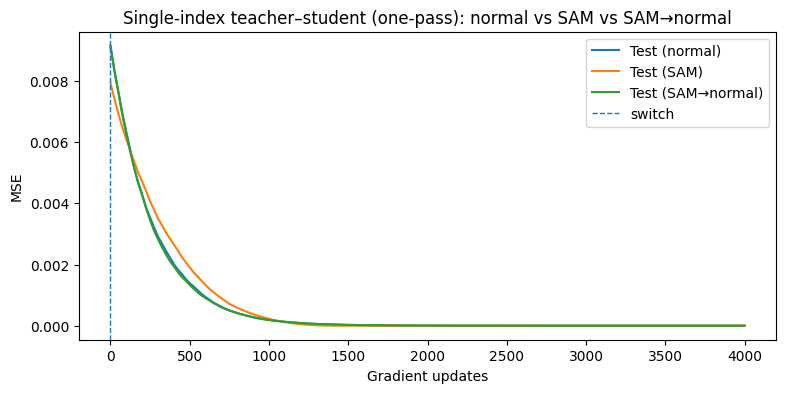

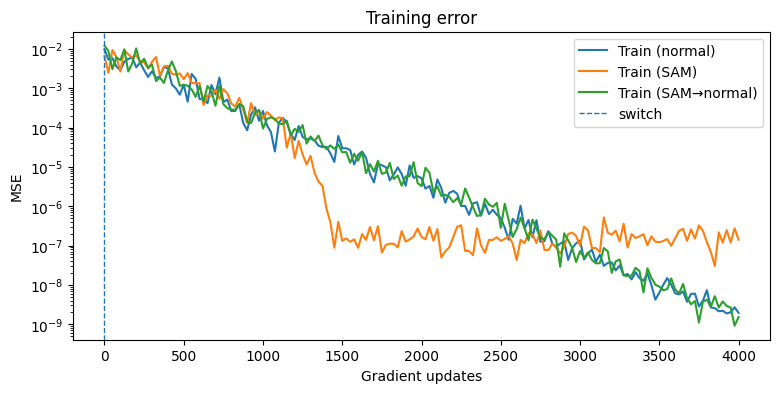

Total gradient updates: 4000
Final test MSE (normal):       1.841656049883511e-09
Final test MSE (SAM):          1.4946103021884483e-07
Final test MSE (SAM→normal):   1.650779735129504e-09


In [17]:

plt.figure(figsize=(9,4))
plt.plot(x_axis, res_normal["test"], label="Test (normal)")
plt.plot(x_axis, res_sam["test"],    label="Test (SAM)")
plt.plot(x_axis, res_sched["test"],  label="Test (SAM→normal)")
plt.axvline(cfg["switch_step"], linestyle="--", linewidth=1, label="switch")
plt.xlabel("Gradient updates")
plt.ylabel("MSE")
# plt.yscale("log")
plt.title("Single-index teacher–student (one-pass): normal vs SAM vs SAM→normal")
plt.legend()
plt.show()

plt.figure(figsize=(9,4))
plt.plot(x_axis, res_normal["train"], label="Train (normal)")
plt.plot(x_axis, res_sam["train"],    label="Train (SAM)")
plt.plot(x_axis, res_sched["train"],  label="Train (SAM→normal)")
plt.axvline(cfg["switch_step"], linestyle="--", linewidth=1, label="switch")
plt.xlabel("Gradient updates")
plt.yscale("log")
plt.ylabel("MSE")
plt.title("Training error")
plt.legend()
plt.show()

print("Total gradient updates:", res_normal["n_updates"])
print("Final test MSE (normal):      ", res_normal["test"][-1])
print("Final test MSE (SAM):         ", res_sam["test"][-1])
print("Final test MSE (SAM→normal):  ", res_sched["test"][-1])

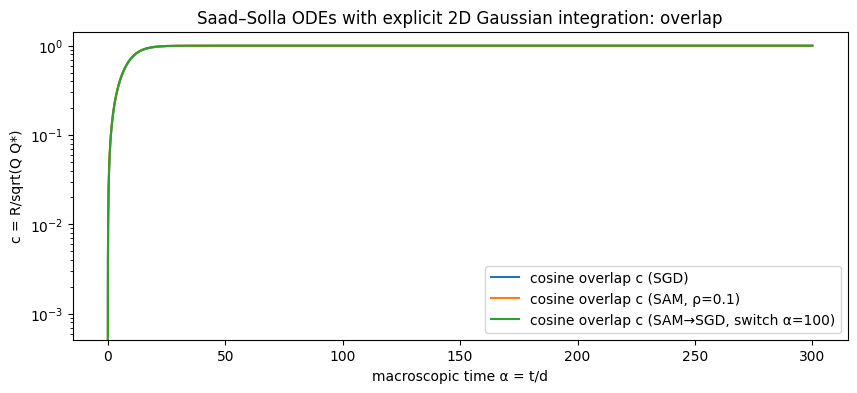

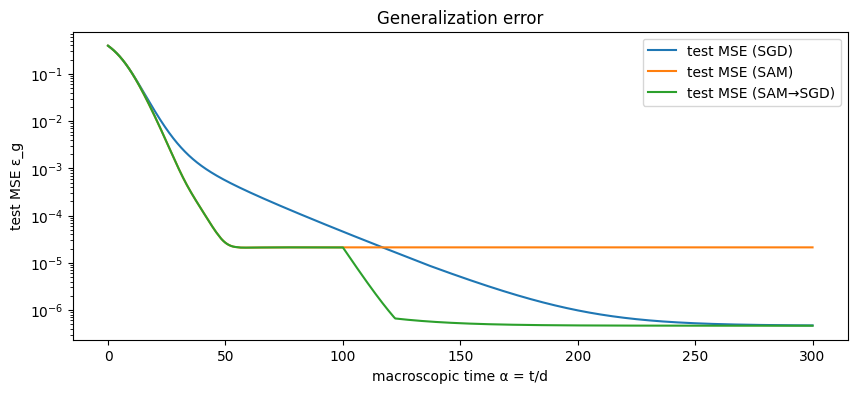

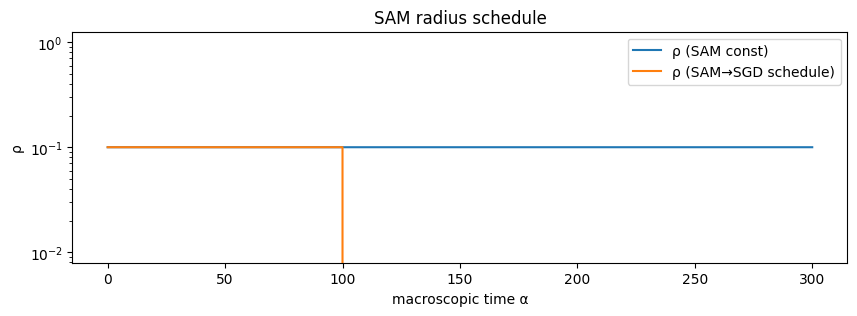

Final SGD:      Q=0.9993, R=0.9997, c=1.0000, test MSE=0.000000
Final SAM:      Q=1.0062, R=1.0031, c=1.0000, test MSE=0.000021
Final SAM→SGD:  Q=1.0001, R=1.0001, c=1.0000, test MSE=0.000000


In [18]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Explicit 2D Gaussian grid integration
# -----------------------------
def make_gaussian_grid(L=6.0, n=121):
    """Create a symmetric grid z in [-L,L] and 2D weights for iid N(0,1).

    Uses simple Riemann/trapezoid weights:
      E[f(Z1,Z2)] ≈ sum_{i,j} f(z_i,z_j) φ(z_i) φ(z_j) Δ^2
    where φ is standard normal pdf.
    """
    z = np.linspace(-L, L, n)
    dz = z[1] - z[0]
    phi = np.exp(-0.5 * z**2) / np.sqrt(2*np.pi)

    Z1 = z[:, None]
    Z2 = z[None, :]

    W = (phi[:, None] * phi[None, :]) * (dz * dz)

    # optional: normalize to make sure sum W ≈ 1 (small truncation error)
    W = W / np.sum(W)
    return Z1, Z2, W

# Precompute grid (increase n for accuracy; increase L for less truncation)
L = 6.0
n_grid = 141   # 121–201 is a reasonable range; larger is slower
Z1, Z2, W = make_gaussian_grid(L=L, n=n_grid)

def _tanh(x):
    return np.tanh(x)

def _sech2(x):
    t = np.tanh(x)
    return 1.0 - t*t

def expectations_tanh_tanh(Q, R, Qstar=1.0, rho=0.0, use_sam=False):
    """Compute Gaussian expectations for the tanh–tanh single-index model.

    (Z1, Z2) ~ iid N(0,1). Construct correlated u* via:
      z* = c Z1 + sqrt(1-c^2) Z2,   with c = R/sqrt(Q Q*).
      u  = sqrt(Q) Z1
      u* = sqrt(Q*) z*

    If use_sam:
      u_adv = u + rho * sign(a(u,u*))
      a_SAM = (tanh(u_adv)-tanh(u*)) * sech^2(u_adv)
      Use a = a_SAM in the ODE expectations.
    Else:
      a = (tanh(u)-tanh(u*)) * sech^2(u)

    Returns:
      E_a_ustar, E_a_u, E_a2, Eg
    where Eg = 0.5 E[(tanh(u)-tanh(u*))^2] (always evaluated at unperturbed u).
    """
    Q = float(max(Q, 1e-12))
    Qstar = float(max(Qstar, 1e-12))

    c = R / np.sqrt(Q * Qstar)
    c = float(np.clip(c, -0.999999, 0.999999))
    s = np.sqrt(1.0 - c*c)

    zstar = c * Z1 + s * Z2
    u  = np.sqrt(Q) * Z1
    us = np.sqrt(Qstar) * zstar

    tu  = _tanh(u)
    tus = _tanh(us)

    # test/generalization error uses unperturbed u
    Eg = 0.5 * np.sum(W * (tu - tus)**2)

    # base a(u,u*)
    a = (tu - tus) * _sech2(u)

    if use_sam and rho != 0.0:
        # SAM shift in the local field (single-index approximation)
        u_adv = u + rho * np.sign(a)
        tu_adv = _tanh(u_adv)
        a = (tu_adv - tus) * _sech2(u_adv)

    E_a_ustar = np.sum(W * a * us)
    E_a_u     = np.sum(W * a * u)
    E_a2      = np.sum(W * a * a)

    return E_a_ustar, E_a_u, E_a2, Eg

# -----------------------------
# Saad–Solla ODE + RK4 integrator (SGD / SAM / schedule)
# -----------------------------
def rhs(Q, R, eta=0.2, B=1, Qstar=1.0, rho=0.0, mode="sgd"):
    use_sam = (mode == "sam")
    E_a_ustar, E_a_u, E_a2, Eg = expectations_tanh_tanh(Q, R, Qstar=Qstar, rho=rho, use_sam=use_sam)
    dR = -eta * E_a_ustar
    dQ = -2.0 * eta * E_a_u + (eta**2 / B) * E_a2
    return dQ, dR, Eg

def integrate(Q0=1.0, R0=0.0, eta=0.2, B=1, Qstar=1.0, alpha_max=6.0, dt=1e-2,
              mode="sgd", rho=0.0, rho_schedule=None):
    """Integrate the ODEs.

    mode: "sgd" or "sam"
    rho: constant SAM radius if rho_schedule is None
    rho_schedule: function rho(alpha) if provided (lets you do SAM→SGD by switching rho to 0)
    """
    n_steps = int(np.ceil(alpha_max / dt))
    Q = float(Q0)
    R = float(R0)

    alphas = np.zeros(n_steps + 1)
    Qs     = np.zeros(n_steps + 1)
    Rs     = np.zeros(n_steps + 1)
    cs     = np.zeros(n_steps + 1)
    Egs    = np.zeros(n_steps + 1)
    rhos   = np.zeros(n_steps + 1)

    def rho_at(a):
        if rho_schedule is None:
            return rho
        return float(rho_schedule(a))

    # initial
    rho0 = rho_at(0.0)
    _, _, _, Eg0 = expectations_tanh_tanh(Q, R, Qstar=Qstar, rho=rho0, use_sam=(mode=="sam"))
    Qs[0], Rs[0], Egs[0] = Q, R, Eg0
    cs[0] = R / np.sqrt(max(Q, 1e-12) * Qstar)
    rhos[0] = rho0

    for k in range(1, n_steps + 1):
        a = k * dt
        rho_k = rho_at(a)

        # RK4 with potentially time-varying rho
        def f(Q_, R_, a_):
            rho_ = rho_at(a_)
            return rhs(Q_, R_, eta=eta, B=B, Qstar=Qstar, rho=rho_, mode=mode)

        k1Q, k1R, _ = f(Q, R, a-dt)
        k2Q, k2R, _ = f(Q + 0.5*dt*k1Q, R + 0.5*dt*k1R, a-0.5*dt)
        k3Q, k3R, _ = f(Q + 0.5*dt*k2Q, R + 0.5*dt*k2R, a-0.5*dt)
        k4Q, k4R, _ = f(Q + dt*k3Q,     R + dt*k3R,     a)

        Q = Q + (dt/6.0)*(k1Q + 2*k2Q + 2*k3Q + k4Q)
        R = R + (dt/6.0)*(k1R + 2*k2R + 2*k3R + k4R)

        Q = float(max(Q, 1e-12))

        # log
        alphas[k] = a
        Qs[k] = Q
        Rs[k] = R
        cs[k] = R / np.sqrt(Q * Qstar)
        rhos[k] = rho_k
        _, _, _, Eg = expectations_tanh_tanh(Q, R, Qstar=Qstar, rho=rho_k, use_sam=(mode=="sam"))
        Egs[k] = Eg

    return alphas, Qs, Rs, cs, Egs, rhos

# -----------------------------
# Run: compare SGD vs SAM vs SAM→SGD schedule
# -----------------------------
Qstar = 1.0
Q0 = 1.0
R0 = 0.0

eta = 0.2
B = 1

alpha_max = 300
dt = 1e-2

rho_const = 0.1           # constant SAM radius (in u-space shift units)
alpha_switch = 100         # switch time for SAM→SGD (rho -> 0)

def rho_sched(a):
    return rho_const if a < alpha_switch else 0.0

# Plain SGD ODE
a_sgd, Q_sgd, R_sgd, c_sgd, Eg_sgd, _ = integrate(
    Q0=Q0, R0=R0, eta=eta, B=B, Qstar=Qstar,
    alpha_max=alpha_max, dt=dt, mode="sgd", rho=0.0
)

# Persistent SAM ODE (constant rho)
a_sam, Q_sam, R_sam, c_sam, Eg_sam, rho_sam = integrate(
    Q0=Q0, R0=R0, eta=eta, B=B, Qstar=Qstar,
    alpha_max=alpha_max, dt=dt, mode="sam", rho=rho_const
)

# SAM→SGD schedule: same SAM ODE but with rho(alpha) that goes to 0
a_sched, Q_sched, R_sched, c_sched, Eg_sched, rho_sched_arr = integrate(
    Q0=Q0, R0=R0, eta=eta, B=B, Qstar=Qstar,
    alpha_max=alpha_max, dt=dt, mode="sam", rho_schedule=rho_sched
)

plt.figure(figsize=(10,4))
plt.plot(a_sgd,  c_sgd,  label="cosine overlap c (SGD)")
plt.plot(a_sam,  c_sam,  label=f"cosine overlap c (SAM, ρ={rho_const})")
plt.plot(a_sched,c_sched,label=f"cosine overlap c (SAM→SGD, switch α={alpha_switch})")
plt.xlabel("macroscopic time α = t/d")
plt.yscale("log")
plt.ylabel("c = R/sqrt(Q Q*)")
plt.title("Saad–Solla ODEs with explicit 2D Gaussian integration: overlap")
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(a_sgd,  Eg_sgd,  label="test MSE (SGD)")
plt.plot(a_sam,  Eg_sam,  label="test MSE (SAM)")
plt.plot(a_sched,Eg_sched,label="test MSE (SAM→SGD)")
plt.yscale("log")
plt.xlabel("macroscopic time α = t/d")
plt.ylabel("test MSE ε_g")
plt.title("Generalization error")
plt.legend()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(a_sam, rho_sam, label="ρ (SAM const)")
plt.plot(a_sched, rho_sched_arr, label="ρ (SAM→SGD schedule)")
plt.yscale("log")
plt.xlabel("macroscopic time α")
plt.ylabel("ρ")
plt.title("SAM radius schedule")
plt.legend()
plt.show()

print(f"Final SGD:      Q={Q_sgd[-1]:.4f}, R={R_sgd[-1]:.4f}, c={c_sgd[-1]:.4f}, test MSE={Eg_sgd[-1]:.6f}")
print(f"Final SAM:      Q={Q_sam[-1]:.4f}, R={R_sam[-1]:.4f}, c={c_sam[-1]:.4f}, test MSE={Eg_sam[-1]:.6f}")
print(f"Final SAM→SGD:  Q={Q_sched[-1]:.4f}, R={R_sched[-1]:.4f}, c={c_sched[-1]:.4f}, test MSE={Eg_sched[-1]:.6f}")
